In [2]:
import pandas as pd
import numpy as np

import shap
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import matthews_corrcoef, classification_report, roc_auc_score

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

<h1 style="text-align:center">Dataset Loading</h1>

In [4]:
def read_data():
    df = pd.read_csv("./input/telomere_geography_health_3_18.csv")
    return df

def categorical_to_numeric(df, column, mapping, regex=False):
    df[column] = df[column].replace(mapping, regex=regex)

def fill_na(df, column, default):
    fill_value = np.nan
    if default == "median":
        fill_value = df[column].median()
    elif default == "mode":
        fill_value = df[column].mode()[0]

    df[column] = df[column].fillna(fill_value)

<h1 style="text-align:center">Data Preprocessing</h1>

In [5]:
def preprocess_data(df):

    categorical_to_numeric(
        df,
        "cigarette_smoking",
        {
            "No information": np.nan,
            "Former Smoker": np.nan,
            "Never Smoker": 0,
            "Occasional Smoker": 1,
            "Regular Smoker": 2,
        },
    )

    categorical_to_numeric(
        df,
        "physical_activity_cohort",
        {
            "No information": np.nan,
            "Sedentary (Inactive)": 0,
            "Minimally Active": 1,
            "Lightly Active": 2,
            "Moderately Active": 3,
            "Highly Active": 4,
        },
    )

    categorical_to_numeric(
        df,
        "alcohol_drinking",
        {
            "No information": np.nan,
            "Former Drinker": np.nan,
            "Never Drinker": 0,
            "Occasional Drinker": 1,
            "Moderate Drinker": 2,
            "Heavy Drinker": 3,
        },
    )

    categorical_to_numeric(
        df,
        "bp_category",
        {
            "No information": np.nan,
            "Hypotension (Low BP)": 0,
            "Normal BP": 1,
            "Elevated BP": 2,
            "Hypertension Stage 1": 3,
            "Hypertension Stage 2": 4,
            "Hypertensive Crisis": 5,
        },
    )

    categorical_to_numeric(
        df,
        "cardiovascular_disease_diagnosis",
        {
            "^No known*": 0,
            "^Non-cardiovascular*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "cancer_diagnosis",
        {
            "^Clinically Healthy*": 0,
            "^Non-oncologic*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "depression_anxiety",
        {
            "^No Known*": 0,
            "^Anxiety and/or*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "allergy",
        {
            "^No Diagnosed*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "diabetes_diagnosis",
        {
            "^No known diagnosis*": 0,
            "^Diagnosed with*": 1,
        },
        regex=True,
    )

    df["hr"] = pd.to_numeric(df["hr"], errors="coerce")
    df["rr"] = pd.to_numeric(df["rr"], errors="coerce")

    fill_na(df, "hr", "median")
    fill_na(df, "rr", "median")
    fill_na(df, "bmi", "median")
    fill_na(df, "alcohol_drinking", "mode")
    fill_na(df, "cigarette_smoking", "mode")
    fill_na(df, "bp_category", "mode")
    fill_na(df, "physical_activity_cohort", "mode")

    df = pd.get_dummies(df, columns=["sex", "rural_or_urban"])
    return df

<h1 style="text-align:center">Model Training</h1>

In [20]:
def train_model(df, to_predict, rs=0):
    y = df.pop(to_predict)
    X = df

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=rs
    )

    # Feature Selection, Scaling and Training Pipeline
    pipeline = Pipeline(
        [
            (
                "selector",
                SelectFromModel(LinearSVC(penalty="l1", dual=False, max_iter=10000)),
            ),
            ("scaler", StandardScaler()),
            ("lsvc", SVC(kernel="linear", probability=True, class_weight="balanced")),
        ]
    )

    # Training Model
    pipeline.fit(X_train, y_train)

    # Pipeline Partitioning
    selector = pipeline.named_steps["selector"]
    scaler = pipeline.named_steps["scaler"]
    lsvc_model = pipeline.named_steps["lsvc"]

    # Feature Variance, Weights
    selected_indeces = np.where(selector.get_support())[0]

    features_names = pd.Series(X_train.columns[selected_indeces])
    feature_names = [name.replace("_", " ").upper() for name in features_names]

    feature_variances = pd.Series(X_train.iloc[:, selected_indeces].var())
    feature_weights = pd.Series(pipeline.named_steps["lsvc"].coef_[0])

    feature_report = pd.DataFrame(
        data={
            "Selected Features": features_names.values,
            "Variances": feature_variances.values,
            "Weights": feature_weights.values,
        }
    )

    feature_report = feature_report.sort_values(by="Weights", key=abs, ascending=False)
    feature_report = feature_report.reset_index(drop=True)

    # Feature Shapley Values
    X_train_selected = selector.transform(X_train)
    X_train_transformed = scaler.transform(X_train_selected)

    X_test_transformed = selector.transform(X_test)
    X_test_transformed = scaler.transform(X_test_transformed)

    explainer = shap.LinearExplainer(lsvc_model, X_train_transformed)
    shap_values = explainer.shap_values(X_test_transformed)

    def shap_plot():
        shap.plots.violin(
            shap_values,
            # features=X_test_transformed,
            feature_names=feature_names,
        )

    # Model Metrics
    y_pred = pipeline.predict(X_test)
    y_probs = lsvc_model.predict_proba(X_test_transformed)

    # Compute Cross-Validation Accuracy
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring="accuracy")
    cv_accuracy = round(np.mean(cv_scores) * 100, 2)

    # Compute Matthew's Coefficient
    matthews_coeff = matthews_corrcoef(y_test, y_pred)
    matthews_coeff = round(matthews_coeff, 2)

    # Test ROC-AUC
    auc_score = roc_auc_score(y_test, y_probs[:, 1])
    auc_score = round(auc_score, 2)

    # Generate Classification Report
    model_report = classification_report(
        y_test, y_pred, target_names=["No Disease", "Disease"], output_dict=True
    )
    model_report = pd.DataFrame(model_report).drop("accuracy", axis=1).T.round(2)

    return (
        cv_accuracy,
        matthews_coeff,
        auc_score,
        feature_report,
        shap_plot,
        model_report,
    )

<h1 style="text-align:center">Cancer Prediction 🎗</h1>

In [21]:
cancer_df = read_data()
cancer_preprocessed = preprocess_data(cancer_df)

(
    cancer_cv_accuracy,
    cancer_matthews_coeff,
    cancer_auc_score,
    cancer_feature_report,
    cancer_shap_plot,
    cancer_model_report,
) = train_model(cancer_preprocessed, "cancer_diagnosis", rs=5349939)

C:\Users\barbie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\barbie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\barbie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\barbie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklear

<h1 style="text-align:center">Features and Model Metrics</h1>

<h2>5-Fold Accuracy</h2>

In [22]:
print(f"5-Fold Cross-Validation Accuracy: {cancer_cv_accuracy}")

5-Fold Cross-Validation Accuracy: 89.95


In [26]:
cancer_feature_report

,Selected Features,Variances,Weights
0,bp_category,1.372805,-2.222141
1,age,371.367385,2.074076
2,rural_or_urban_Rural,0.133224,-1.382796
3,physical_activity_cohort,1.542257,-1.291405
4,alcohol_drinking,0.637217,-1.091808
5,cigarette_smoking,0.417026,0.696153
6,allergy,0.099956,-0.560079
7,cardiovascular_disease_diagnosis,0.198879,0.469256
8,hr,144.741502,-0.420953
9,sex_Male,0.250491,0.279334


<h2>Feature Shapley Values</h2>

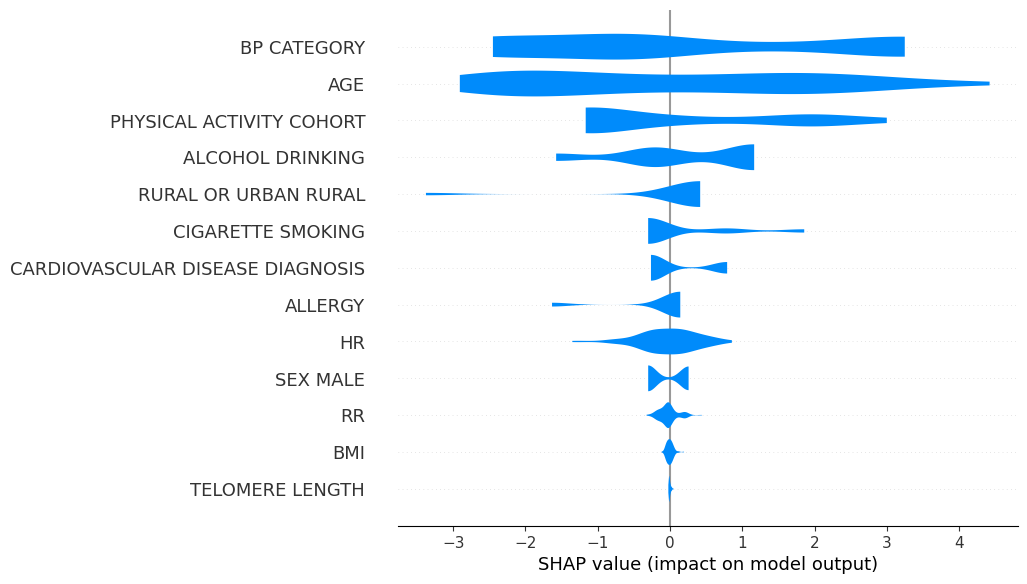

In [27]:
cancer_shap_plot()